<h1> Gradient Boosting

Importiamo il dataset training_c

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
data = pd.read_csv('data/training_c.csv')
data

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25.0,130,80.0,72.0,98.0,86.0,high risk
1,35.0,140,90.0,72.0,98.0,70.0,high risk
2,29.0,90,70.0,72.0,100.0,80.0,high risk
3,30.0,140,85.0,72.0,98.0,70.0,high risk
4,35.0,120,60.0,61.0,98.0,76.0,low risk
...,...,...,...,...,...,...,...
1004,48.0,120,80.0,72.0,98.0,88.0,high risk
1005,22.0,120,60.0,72.0,98.0,80.0,high risk
1006,55.0,120,90.0,72.0,98.0,60.0,high risk
1007,35.0,85,60.0,72.0,98.0,86.0,high risk


Dividiamo il dataset in training set e test set

In [2]:
# Divisione in training e test
X = data.drop("RiskLevel", axis=1)  # Separiamo le colonne contenenti le feature (escludendo "RiskLevel")
y = data['RiskLevel']  # Estrazione della colonna target ("RiskLevel")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Con il RandomizedSearch troviamo i migliori parametri da utilizzare nel gradient boosting

In [3]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Definizione di intervalli di parametri da utilizzare nel Randomized
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4]
}
model = GradientBoostingClassifier(random_state=42) #crea un'istanza del modello GradientBoostingClassifier di scikit-learn


# Randomized Search
random_search = RandomizedSearchCV(
    model, param_distributions, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)

# Addestramento con ricerca casuale
random_search.fit(X_train, y_train)

# Migliori parametri trovati
print("Migliori parametri:", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Migliori parametri: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.20333333333333334}


Implementiamo il modello Gradient Boosting con scikit learn con i parametri trovati dal RandomizedSearch

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Recupero i migliori parametri trovati dal Randomized
best_params = random_search.best_params_

# Crea un nuovo modello Gradient Boosting con i migliori parametri
final_model = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
    
)

# Addestra il modello sull'intero training set
final_model.fit(X_train, y_train)

# Predizioni sul test set
y_pred = final_model.predict(X_test)

# Valutazione del modello
print(f"Accuratezza sul test set: {accuracy_score(y_test, y_pred):.2f}")
print("\nReport di classificazione:")
print(classification_report(y_test, y_pred))


Accuratezza sul test set: 0.89

Report di classificazione:
              precision    recall  f1-score   support

   high risk       0.92      0.91      0.92        54
    low risk       0.89      0.91      0.90        81
    mid risk       0.85      0.84      0.84        67

    accuracy                           0.89       202
   macro avg       0.89      0.89      0.89       202
weighted avg       0.89      0.89      0.89       202



Valutiamo la matrice di confusione

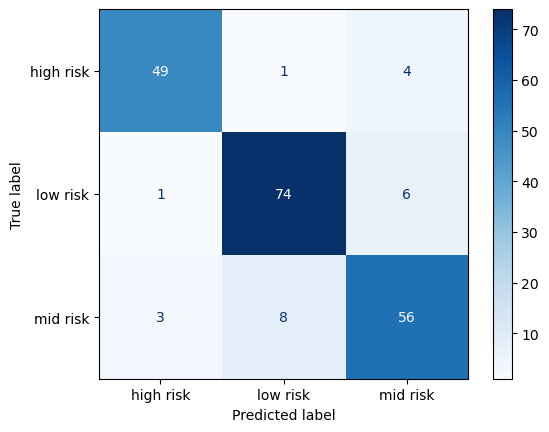

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Creazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=final_model.classes_)

# Visualizzazione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap="Blues")


Vediamo qual è la feature più influente nel nostro dataset. L'importanza delle feature in Gradient Boosting è calcolata sulla base del numero di volte che una feature viene utilizzata per suddividere i dati durante la costruzione degli alberi, e quanto questa suddivisione migliora la predizione.
Se una feature viene scelta frequentemente per suddividere i dati nei nodi più importanti degli alberi , la sua importanza sarà maggiore.


       Feature  Importance
1   SystolicBP    0.325085
3           BS    0.242099
0          Age    0.178266
4     BodyTemp    0.096261
5    HeartRate    0.086549
2  DiastolicBP    0.071739


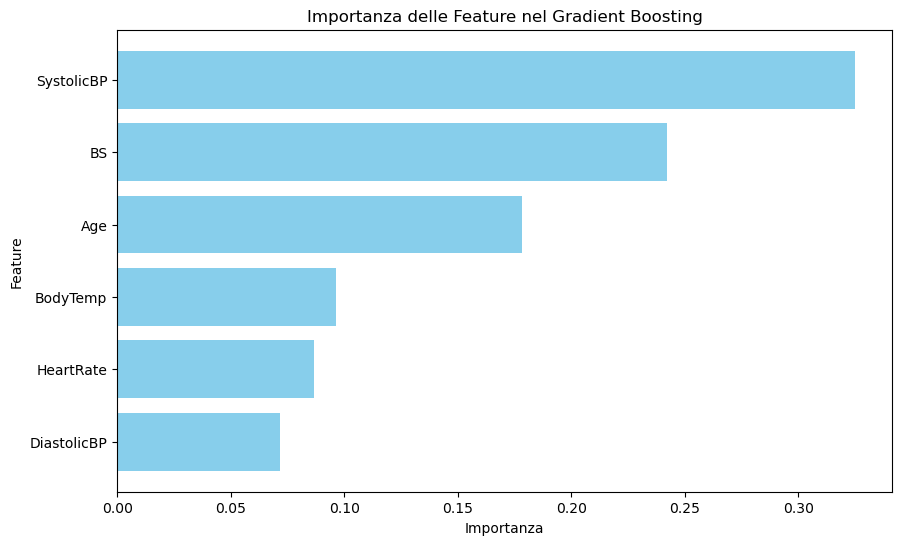

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = final_model.feature_importances_
#final_model.feature_importances_ è un attributo del modello GradientBoostingClassifier che restituisce un array contenente
#l'importanza relativa di ciascuna feature utilizzata dal modello.

# Creazione di un DataFrame per organizzare i dati
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)



print(importance_df)

# Visualizzazione di  un grafico a barre delle feature
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Inversione dell'asse y per vedere la feature più importante in alto
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.title('Importanza delle Feature nel Gradient Boosting')
plt.show()


La pressione sistolica (SystolicBP) è la feature più influente nel  modello, rappresentando circa il 33.25% dell'importanza totale. Ciò significa che il modello dipende molto da questa variabile per fare le sue previsioni.

Visualizziamo alcune curve utili per comprendere le prestazioni del modello e come si comporta con il dataset

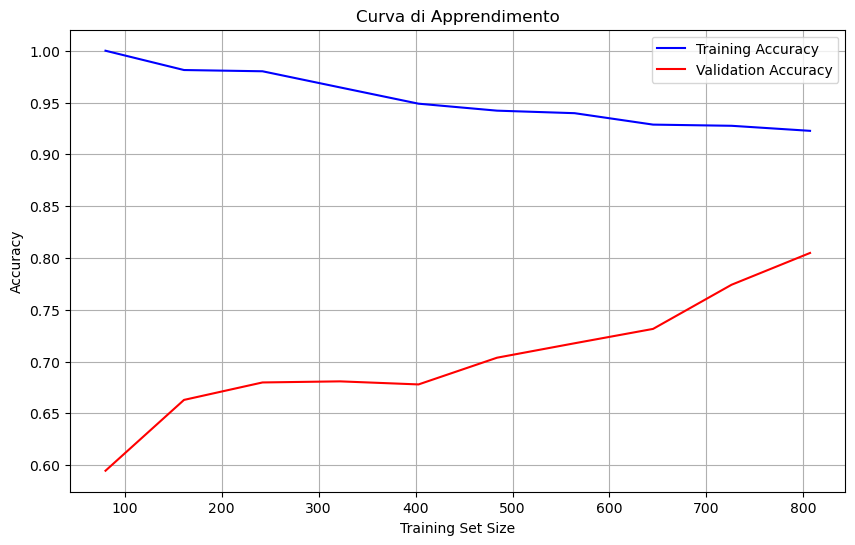

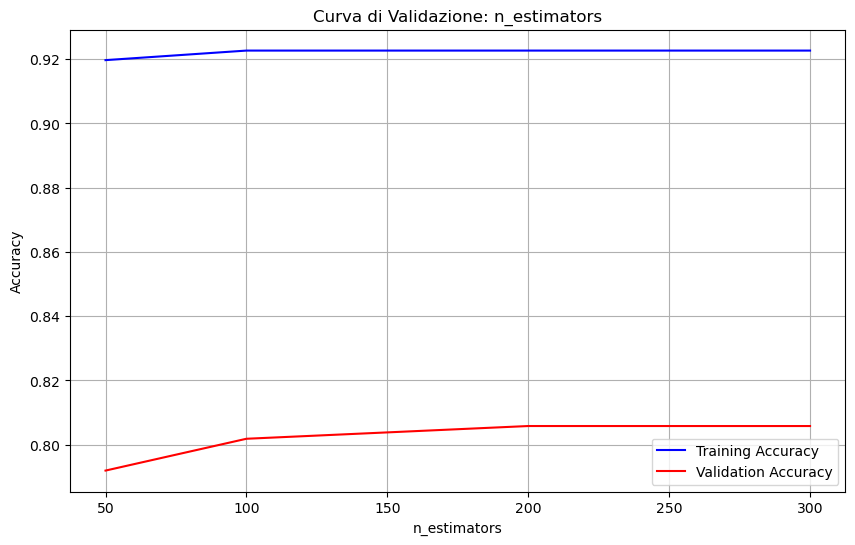

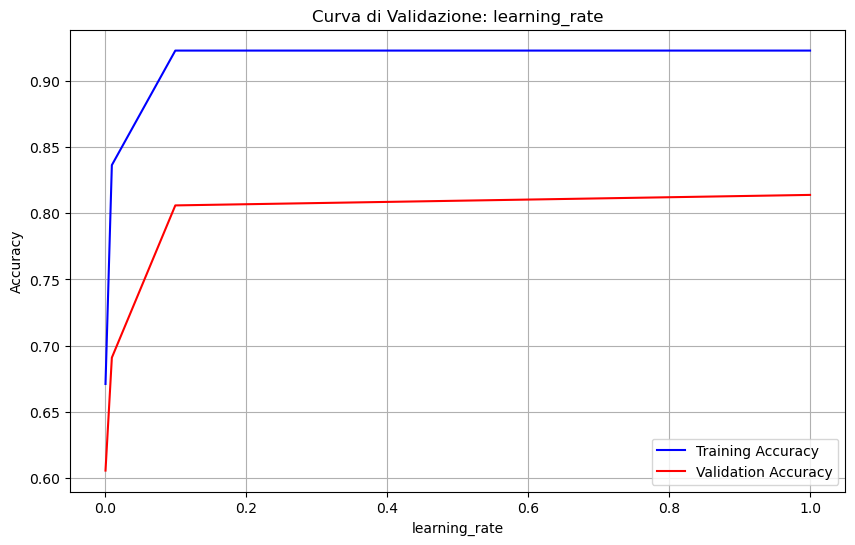

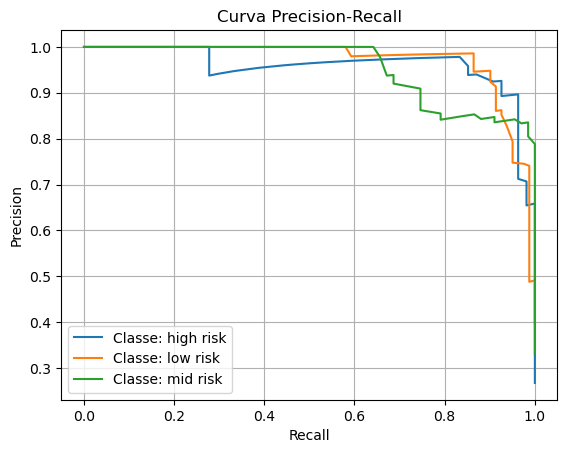

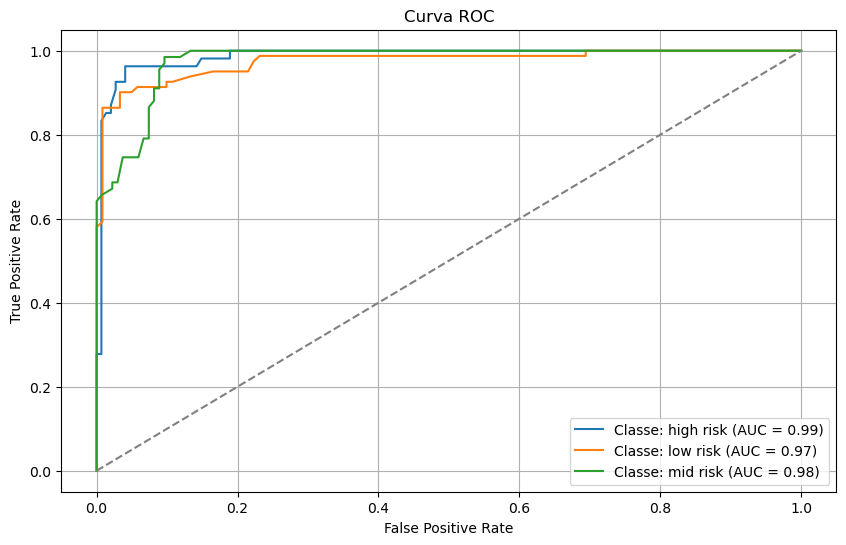

In [7]:

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score
from sklearn.model_selection import learning_curve, validation_curve

# --- 1. CURVA DI APPRENDIMENTO ---
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
    plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Curva di Apprendimento')
    plt.legend()
    plt.grid()
    plt.show()

# --- 2. CURVA DI VALIDAZIONE ---
def plot_validation_curve(model, X, y, param_name, param_range, cv=5):
    train_scores, val_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring='accuracy', n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, label='Training Accuracy', color='blue')
    plt.plot(param_range, val_mean, label='Validation Accuracy', color='red')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.title(f'Curva di Validazione: {param_name}')
    plt.legend()
    plt.grid()
    plt.show()

# --- 3. CURVA PRECISION-RECALL ---
def plot_precision_recall_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)
    for i, class_label in enumerate(model.classes_):
        precision, recall, _ = precision_recall_curve(y_test == class_label, y_prob[:, i])
        plt.plot(recall, precision, label=f'Classe: {class_label}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall')
    plt.legend()
    plt.grid()
    plt.show()

# --- 4. CURVA ROC-AUC (OPZIONALE) ---
def plot_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)
    plt.figure(figsize=(10, 6))

    for i, class_label in enumerate(model.classes_):
        fpr, tpr, _ = roc_curve(y_test == class_label, y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Classe: {class_label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.grid()
    plt.show()

# Esecuzione dei grafici

plot_learning_curve(final_model, X, y)

# Curva di validazione per un iperparametro
plot_validation_curve(final_model, X, y, param_name='n_estimators', param_range=[50, 100, 200, 300])
plot_validation_curve(final_model, X, y, param_name='learning_rate', param_range=[0.001, 0.01, 0.1, 1.0], cv=5)

# Precision-Recall
plot_precision_recall_curve(final_model, X_test, y_test)

# ROC-AUC 
plot_roc_curve(final_model, X_test, y_test)
